In [1]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 19.1MB/s 


In [2]:
'''
why do we train, instead of using the pretrained weights for MobileNetV2?
thats is because the MobileNetV2 does not correctly detect rotated images
so we need to apply transfer learning, using a MobileNetV2 as our base model
'''

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

tfds.disable_progress_bar()

train_samples = 5000
validation_samples = 1000

In [3]:
'''
make dataset with cat and dog images
labels: 0 - cat, 1 - dog
'''

train_split = train_samples * 2
validation_split = validation_samples * 2
split = ['train[:%d]' % train_split, 'train[%d:%d]' % (train_split, train_split + validation_split)]

catsdogs_train, catsdogs_validation = tfds.load('cats_vs_dogs', split=split, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteFL69WR/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [5]:
'''
make a dataset for 'unknown_class' label
download the imagenet_v2 dataset and exclude cat and dog images
change the label for every class
label: 2 - unknown_class

cat and dog label bounds are taken from here:
https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json
'''

is_cat_label = lambda label: 281 <= label and label <= 285
is_dog_label = lambda label: 151 <= label and label <= 268

others = tfds.load('imagenet_v2', split='test', as_supervised=True)
others = others.filter(lambda image, label: not is_cat_label(label) and not is_dog_label(label))
others = others.take(train_samples + validation_samples)
others = others.map(lambda image, label: (image, tf.constant(2, tf.int64)))

others_train = others.take(train_samples)
others_validation = others.skip(train_samples).take(validation_samples)

Shuffling and writing examples to /root/tensorflow_datasets/imagenet_v2/matched-frequency/1.0.0.incompleteE97I4N/imagenet_v2-test.tfrecord
Dataset imagenet_v2 downloaded and prepared to /root/tensorflow_datasets/imagenet_v2/matched-frequency/1.0.0. Subsequent calls will reuse this data.


In [6]:
'''
concatenate "catsdogs" dataset with "others" dataset
labels: 0 - cat, 1 - dog, 2 - unknown_class
shuffle train and validation datasets
'''

train = catsdogs_train.concatenate(others_train)
validation = catsdogs_validation.concatenate(others_validation)

train = train.shuffle(train_samples * 3)
validation = validation.shuffle(validation_samples * 3)

print('Number of train samples: %d' % train.reduce(0, lambda n, _ : n + 1))
print('Number of validation samples: %d' % validation.reduce(0, lambda n, _ : n + 1))

Number of train samples: 15000
Number of validation samples: 3000


In [7]:
'''
MobileNetV2 requires images to be 224x224, lets resize them
apply random rotation angle, either 0, 90, 180 or 270 degrees
0.5pi = 90 degrees
'''
import numpy as np

size = (224, 224)
resize = lambda image, label: (tf.image.resize(image, size), label)

train = train.map(resize)
validation = validation.map(resize)

kwargs = {'shape': [], 'minval': 0, 'maxval': 4, 'dtype': tf.int32}
half_pi = tf.constant(0.5 * np.pi, tf.float32)
rotate = lambda image, label: (tfa.image.rotate(image, tf.cast(tf.random.uniform(**kwargs), tf.float32) * half_pi), label)

train = train.map(rotate)
validation = validation.map(rotate)

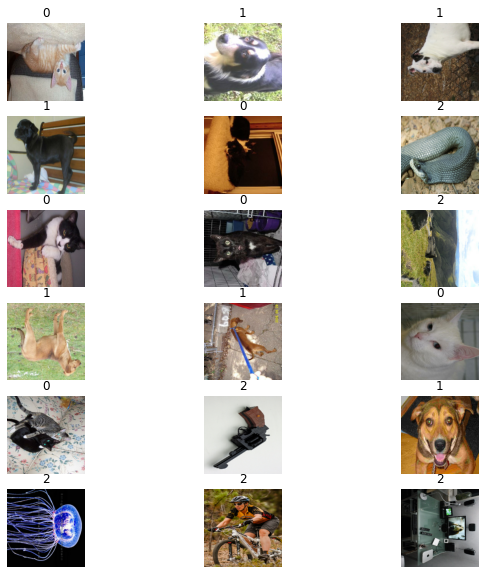

In [8]:
'''
lets check how the images with labels look like
'''

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train.take(18)):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image.numpy().astype('int32'))
    plt.title(int(label))
    plt.axis('off')

In [9]:
'''
preprocess images for MobileNetV2
"preprocess_input" normalizes pixel values to range [-1, 1]
'''
from keras.applications.mobilenet_v2 import preprocess_input

preprocess = lambda image, label: (preprocess_input(image), label)

train = train.map(preprocess)
validation = validation.map(preprocess)

In [10]:
'''
lets check how the normalized values look like in array
'''

for image, label in train.take(1):
  print(image)

tf.Tensor(
[[[-0.4383222  -0.485381   -0.65793   ]
  [-0.45334107 -0.5003998  -0.6729489 ]
  [-0.43954408 -0.4866029  -0.6591519 ]
  ...
  [-0.04702151 -0.24019372 -0.4435423 ]
  [-0.05569118 -0.25961274 -0.4712696 ]
  [-0.07085127 -0.27477288 -0.48653758]]

 [[-0.3242134  -0.37911534 -0.5214822 ]
  [-0.34022737 -0.39512932 -0.53749627]
  [-0.291265   -0.34616697 -0.48853397]
  ...
  [-0.07085079 -0.27067578 -0.44313723]
  [-0.07323176 -0.28380603 -0.45089287]
  [-0.07970941 -0.29028362 -0.45737046]]

 [[-0.06723928 -0.12998438 -0.23068464]
  [-0.08912128 -0.15186638 -0.25256664]
  [-0.05967635 -0.12242144 -0.22312176]
  ...
  [-0.06917036 -0.27179623 -0.38861465]
  [-0.07324928 -0.2771709  -0.40782213]
  [-0.06540614 -0.26932776 -0.40014005]]

 ...

 [[ 0.2798972   0.37401485  0.4693929 ]
  [ 0.27851164  0.37262928  0.46800745]
  [ 0.29101872  0.38513637  0.4805144 ]
  ...
  [-0.297018   -0.24457872 -0.2045461 ]
  [-0.3013376  -0.28422987 -0.19036072]
  [-0.24173433 -0.2476868  -0.127

In [11]:
'''
batch the data, apply prefetching to optimize training performance
https://keras.io/guides/transfer_learning/
'''

batch_size = 32

train = train.batch(batch_size).prefetch(buffer_size=10)
validation = validation.batch(batch_size).prefetch(buffer_size=10)

In [12]:
from keras.applications import MobileNetV2
from keras import Input, Model
from keras.layers import GlobalAveragePooling2D, Dropout, Dense

'''
now we follow steps suggested here: https://keras.io/guides/transfer_learning/
create base MobileNetV2 model (without last layer) and freeze it
create new layers on top of base model
'''

base_model = MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

'''
the base model contains batchnorm layers
we want to keep them in inference mode when we unfreeze the base model for fine-tuning
so to make sure that the base_model is running in inference mode we set "training=False"
'''

inputs = Input(shape=(224, 224, 3))
outputs = base_model(inputs, training=False)
outputs = GlobalAveragePooling2D()(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(3, activation='softmax')(outputs)
model = Model(inputs, outputs)

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy

model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalAccuracy()])

epochs = 20
model.fit(train, epochs=epochs, validation_data=validation)

Epoch 1/20
469/469 [==============================] - 152s 218ms/step - loss: 0.4055 - sparse_categorical_accuracy: 0.8383 - val_loss: 0.1450 - val_sparse_categorical_accuracy: 0.9523
Epoch 2/20
469/469 [==============================] - 118s 196ms/step - loss: 0.1722 - sparse_categorical_accuracy: 0.9396 - val_loss: 0.1415 - val_sparse_categorical_accuracy: 0.9510
Epoch 3/20
469/469 [==============================] - 106s 188ms/step - loss: 0.1598 - sparse_categorical_accuracy: 0.9472 - val_loss: 0.1400 - val_sparse_categorical_accuracy: 0.9523
Epoch 4/20
469/469 [==============================] - 110s 184ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.1367 - val_sparse_categorical_accuracy: 0.9517
Epoch 5/20
469/469 [==============================] - 120s 204ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.9507 - val_loss: 0.1358 - val_sparse_categorical_accuracy: 0.9510
Epoch 6/20
469/469 [==============================] - 103s 183ms/step - loss: 0.

In [14]:
'''
fine-tune the model using small learning rate: 1e-5
unfreeze the base_model
it keeps running in inference mode since we passed "training=False" when calling it
this means that the batchnorm layers will not update their batch statistics
this prevents the batchnorm layers from undoing all the training we have done so far
'''

base_model.trainable = True
model.summary()

model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalAccuracy()])

epochs = 10
model.fit(train, epochs=epochs, validation_data=validation)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 159s 289ms/step - loss: 0.1362 - sparse_categorical_accura

In [15]:
'''
save the model that we could later use it in our application
'''

model.save('cats_vs_dogs.h5')